In [1]:
from testproblems import generate_random_prob
from representations import bipartite_repr
from inputresolver import resolve,invert_edges,getallvars,direct_eqs
from datastructures.polycasebuilder import eqv_to_edges_tree
from datastructures.graphutils import flat_graph_formulation, draw_graph_graphical_props, VAR, COMP, SOLVER, Node, namefromid, copy_dicts
from datastructures.operators import sort_scc
#from networkx.algorithms.bipartite import random_graph as bipartite_random_graph

In [2]:
from datastructures.tearing import min_arc_set_assign, dir_graph
from datastructures.rendering import render_incidence
from datastructures.graphutils import all_edges, edges_to_Ein_Eout
from collections import OrderedDict
import matplotlib.pyplot as plt
from itertools import chain

In [3]:
import networkx as nx

# Parameters

In [4]:
n_eqs = 10
n_vars = 13
seed = 10#8 is triang#seed 10 is nice 42
sparsity = 1.7#0.87#0.8 1.1 #1.7 1.3

# Setup

In [5]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}

In [6]:
namingfunc = namefromid(nodetyperepr)

# Original indexation

In [7]:
eqv, varinc, output_idx = generate_random_prob(n_eqs, n_vars, seed, sparsity)
_, edges_original = bipartite_repr(eqv)
eqs = direct_eqs(eqv, output_idx)
varidxs = getallvars(eqs, sympy=False)
eqnidxs = set(eqs.keys())

# Display indexation

In [8]:
output_reidx = {key:var-n_eqs for key,var in output_idx.items()}
edges, tree = eqv_to_edges_tree(eqv, output_reidx, n_eqs)

# Original

In [60]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
maxscc = max([len(elt) for elt in merge_order])

In [61]:
elim_edges_default = [comp.name for elt in merge_order for comp in elt if len(elt)>1]

In [62]:
G1 = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)
elimedges1 = [(Node(int(elt),COMP,nodetyperepr), Node(output_reidx[elt], VAR,nodetyperepr)) for elt in elim_edges_default]
Ftree_default = OrderedDict([(elt.name,'solver') for comp in merge_order for elt in comp])
Einn, Eoutn, Rinn = copy_dicts(edges)
_, Stree, Vtree = copy_dicts(tree)
for comp,out in elimedges1:
    Eoutn[comp.name] = (None,) 
    Rinn[comp.name] = (out.name,)
    Vtree[out.name] = 'solver'
    Stree = {'solver':'root'}
edges_default = Einn, Eoutn, Rinn
tree_default = Ftree_default, Stree, Vtree

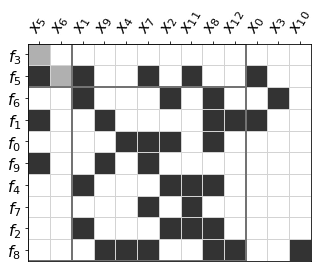

In [63]:
_, ax = render_incidence(edges_default, tree_default, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'orig_10x13.png', dpi=300, bbox_inches='tight')

# Optimize

In [9]:
xsol, _ = min_arc_set_assign(edges_original, varidxs, eqnidxs)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-02-25


In [10]:
selected = dict((right, left-n_eqs) for left, right in edges_original if xsol[left, right] > 0.5)

In [11]:
selected

{0: 2, 1: 0, 2: 1, 3: 5, 5: 6, 6: 3, 7: 11, 8: 4, 9: 7}

In [65]:
Ein_minassign, Eout_minassign, Rin_minassign = dict(), dict(), dict()
Ein_old, Eout_old, _ = edges
_, Stree, Vtree = copy_dicts(tree)
Stree = {'solver':'root'}
for comp in Eout_old.keys():
    if comp in selected:
        var = selected[comp]
        Eout_minassign[comp] = (var,)
        Ein_minassign[comp] = tuple(elt for elt in chain(Ein_old[comp],Eout_old[comp]) if elt!=var)
    else:
        old_out_var = Eout_old[comp][0]
        Eout_minassign[comp] = (None,)
        Rin_minassign[comp] = Eout_old[comp]
        Ein_minassign[comp] = Ein_old[comp]
        solve_var = next(elt for elt in chain(Ein_old[comp],Eout_old[comp]) if elt not in selected.values() and elt not in Vtree.keys()) 
        Vtree[solve_var] = 'solver'

In [66]:
nodetyperepr = {VAR: 'x_{{{}}}', COMP: 'f_{{{}}}', SOLVER: '{}'}
edges_minassign = Ein_minassign, Eout_minassign, Rin_minassign
G2 = flat_graph_formulation(*edges_minassign, nodetyperepr=nodetyperepr)

In [67]:
minassign_order = sort_scc(G2)

In [68]:
Ftree_mina = OrderedDict([(next(iter(comp)).name,'solver') for comp in minassign_order])

In [69]:
tree_minassign = Ftree_mina, Stree, Vtree

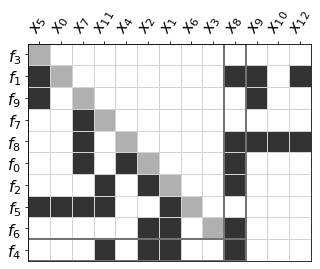

In [70]:
_, ax = render_incidence(edges_minassign, tree_minassign, namingfunc, displaysolver=True)
plt.sca(ax)
plt.savefig(r'minmatch_10x13.png', dpi=300, bbox_inches='tight')

# Validation

In [73]:
for key,var in Ein.items():
    print(sorted(var+ Eout[key]))

[2, 4, 7, 8]
[0, 5, 8, 9, 12]
[1, 2, 8, 11]
[5]
[1, 2, 8, 11]
[0, 1, 5, 6, 7, 11]
[1, 2, 3, 8]
[7, 11]
[4, 7, 8, 9, 10, 12]
[5, 7, 9]


In [74]:
for key,var in Ein_minassign.items():
    outvar = Eout_minassign[key]
    print(sorted(var+ (outvar if outvar[0] is not None else tuple())))

[2, 4, 7, 8]
[0, 5, 8, 9, 12]
[1, 2, 8, 11]
[5]
[1, 2, 8, 11]
[0, 1, 5, 6, 7, 11]
[1, 2, 3, 8]
[7, 11]
[4, 7, 8, 9, 10, 12]
[5, 7, 9]
